In [156]:
%%capture
import os
import shutil

contents = os.listdir()

for item in contents:
    if os.path.isfile(item):
        os.remove(item)
        print(f"Удален файл: {item}")
    elif os.path.isdir(item):
        shutil.rmtree(item)
        print(f"Удалена папка: {item}")

In [157]:
%%capture
!pip install lightning

In [158]:
import os
import random
from glob import glob
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision
from lightning.pytorch.callbacks import Callback
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy, Dice, JaccardIndex, Precision, Recall
from torchvision import transforms
from torchvision.utils import make_grid

In [159]:
torch.manual_seed(2004)

## Сегментация изображений клеток

Вам предстоит обучить модель сегментировать изображения с дрожжевыми клетками и микроструктурами (см. [06_segmentation.ipynb](../workshops/06_segmentation.ipynb)), по пути поэкспериментировав с разными архитектурами и функцими ошибки.

### Задание 1 (2 балл). Метрики сегментации
Перед экспериментами нужно определиться с метриками. Выберите 3-5 метрик, по которым вы будете оценивать качество модели. В этом задании объясните свой выбор и найдите нужные метрики в `torchvision` (а если их нет - реализуйте самостоятельно, здесь вам может помочь [05_lightning_etc.ipynb](../workshops/05_lightning_etc.ipynb))

1. Индекс Жаккара (IoU).

Одна из наиболее распространенных метрик для задач сегментации. Измеряет степень перекрытия между предсказанной и истинной масками.
IoU эффективно оценивает точность сегментации, учитывая как ложноположительные, так и ложноотрицательные пиксели. Это особенно важно для сегментации клеток, где нас интересуют точные границы.

In [160]:
from torchmetrics import JaccardIndex

2. Коэффициент Дайса.

Эта метрика особенно полезна, когда классы несбалансированы, что часто встречается в биологических изображениях (наш случай). Коэффициент Дайса более чувствителен к небольшим изменениям в сегментации, чем IoU. Это делает его полезным для оценки сегментации мелких структур, которые могут присутствовать в микроструктурах и дрожжевых клетках.

In [161]:
from torchmetrics import Dice

3. Средняя точность по классам (Mean Class Accuracy).

Вычисляет точность отдельно для каждого класса и затем усредняет результаты. Она полезна при наличии нескольких классов микроструктур и помогает оценить качество сегментации для каждого класса.

In [162]:
class MeanClassAccuracy(torchmetrics.Metric):
    def __init__(self, num_classes: int = 3, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.num_classes = num_classes
        self.add_state("correct", default=torch.zeros(num_classes), dist_reduce_fx="sum")
        self.add_state("total", default=torch.zeros(num_classes), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = preds.view(preds.shape[0], self.num_classes, -1)
        target = target.view(target.shape[0], -1)
        preds = torch.argmax(preds, dim=1)

        for cls in range(self.num_classes):
            pred_cls = preds == cls
            true_cls = target == cls

            self.correct[cls] += torch.sum(pred_cls & true_cls)
            self.total[cls] += torch.sum(true_cls)

    def compute(self):
        per_class_accuracy = torch.where(
            self.total > 0, self.correct / self.total, torch.zeros_like(self.total)
        )

        return torch.mean(per_class_accuracy)

4. Pixel Accuracy.

Простая метрика для измерения доли правильно классифицированных пикселей. Она дает общее представление о качестве сегментации, но менее чувствительна к точности границ.

In [163]:
class PixelAccuracy(torchmetrics.Metric):
    def __init__(self):
        super().__init__()
        self.add_state("correct", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        pred_label = preds.argmax(dim=1)
        self.correct += (pred_label == target).sum().cpu()
        self.total += target.numel()

    def compute(self):
        return self.correct.float() / self.total

### Задание 2 (4 балла). Обучение модели
Возьмите модель и датасеты из практики по сегментации и запустите обучение.

Указания:
- Каждую эпоху сохраняйте значения ошибки и выбранные в задании 1 метрики как для обучающего датасета (`train`), так и для валидационного (`val`).
- Каждую эпоху сохраняйте примеры работы модели на 8 случайных изображениях из валидационного датасета (одной картинкой, как в практике).
- После окончания обучения выведите графики значений ваших метрик и примеры предсказаний (достаточно 4-5 изображений: для первой эпохи, 2-3 в середине обучения и ндля последней эпохи).
- Можете использовать `lightning` (вместо `lightning.pytorch.loggers.TensorBoardLogger` можно использовать `lightning.pytorch.loggers.CSVLogger`, а сохранение изображений можете реализовать как `lightning.pytorch.Callback`), а можете всё написать вручную.

In [164]:
%%capture
! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

In [165]:
class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(
            0
        )  # (W, H) -> (1, W, H)
        classes = (
            torch.load(
                self.subset_dir / "classes" / image_path.parts[-1], weights_only=True
            )
            + 1
        )  # 0 класс - фон
        masks = torch.load(
            self.subset_dir / "instances" / image_path.parts[-1], weights_only=True
        )
        boxes = torch.load(
            self.subset_dir / "bounding_boxes" / image_path.parts[-1], weights_only=True
        )
        return image, dict(
            boxes=boxes,
            labels=classes,
            masks=masks,
        )

    def __len__(self) -> int:
        return len(self.items)

In [166]:
class YeastSemanticSegmDataset(YeastDataset):
    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image, annotation = super().__getitem__(index)
        # нужно сформировать маску: тензор размера W x H, где для каждого пиксела указан класс
        mask = (
            (annotation["masks"] * annotation["labels"].view(-1, 1, 1)).sum(dim=0)
        ).long()

        return image, mask

In [167]:
from typing import Any, Callable, Type

from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader

_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]


class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        dataset_class: Type[Dataset],
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset_class = dataset_class
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    @property
    def collate_fn(self) -> _collate_fn_t | None:
        if self.dataset_class == YeastSemanticSegmDataset:
            return None
        else:
            return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = self.dataset_class(self.val_dir)
        if stage == "fit":
            self.train_dataset = self.dataset_class(self.train_dir)
        elif stage == "test":
            self.test_dataset = self.dataset_class(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

In [168]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)

In [169]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.maxpool_conv(x)

In [170]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(
        self, in_channels: int, out_channels: int, bilinear: bool = True
    ) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        # input is BCHW
        d_height = x_skip.size()[2] - x_prev.size()[2]
        d_width = x_skip.size()[3] - x_prev.size()[3]

        x_prev = F.pad(
            x_prev,
            [
                d_width // 2,
                d_width - d_width // 2,
                d_height // 2,
                d_height - d_height // 2,
            ],
        )
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)

In [171]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

In [172]:
# def create_classification_metrics(
#     num_classes: int, prefix: str
# ) -> torchmetrics.MetricCollection:
#     return torchmetrics.MetricCollection(
#         [
#             JaccardIndex(task="multiclass", num_classes=num_classes),
#             Dice(num_classes=num_classes, average='macro'),
#             Accuracy(task="multiclass", num_classes=num_classes),
#             Precision(task="multiclass", average='macro', num_classes=num_classes),
#             Recall(task="multiclass", average='macro', num_classes=num_classes),
#         ],
#         prefix=prefix,
#     )

def create_classification_metrics(
    num_classes: int, prefix: str
) -> torchmetrics.MetricCollection:
    return torchmetrics.MetricCollection(
        [
            JaccardIndex(task="multiclass", num_classes=num_classes),
            Dice(num_classes=num_classes, average='macro'),
            torchmetrics.classification.MulticlassAUROC(
                num_classes=num_classes, average="macro"
            ),
            MeanClassAccuracy(),
            PixelAccuracy(),
        ],
        prefix=prefix,
    )

class UNetModule_with_loss(L.LightningModule):
    def __init__(self, model: nn.Module, optimizer, loss_function, learning_rate: float = 0.001) -> None:
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.train_metrics = create_classification_metrics(
            num_classes=3, prefix="train_"
        )
        self.val_metrics = create_classification_metrics(num_classes=3, prefix="val_")

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> Any:
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_function(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        self.train_metrics.update(y_hat, y)
        self.log_dict(self.train_metrics, on_step=False, on_epoch=True)
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> Any:
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_function(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        self.val_metrics.update(y_hat, y)
        self.log_dict(self.val_metrics, on_step=False, on_epoch=True)
        return {
            "loss": loss,
            "preds": y_hat,
        }

    def configure_optimizers(self) -> dict[str, Any]:
      optimizer = self.optimizer(self.model.parameters(), lr=self.learning_rate)
      return {
          "optimizer": optimizer,
          "lr_scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3),
          "monitor": "val_loss"
      }

In [173]:
class VisualizationCallback(Callback):
    def __init__(self, num_samples=8, num_exp=0):
        super().__init__()
        self.num_samples = num_samples
        self.num_exp = num_exp
        self.saved_images = {}

    def on_validation_epoch_end(self, trainer, pl_module):
        val_dataloader = trainer.datamodule.val_dataloader()
        batch = next(iter(val_dataloader))
        images, masks = batch

        indices = random.sample(range(len(images)), min(self.num_samples, len(images)))
        images = images[indices]
        masks = masks[indices]

        images = images.to(pl_module.device)
        masks = masks.to(pl_module.device)

        with torch.no_grad():
            preds = pl_module(images)
        preds = torch.argmax(preds, dim=1)

        fig, axs = plt.subplots(2, self.num_samples, figsize=(20, 8))
        for i in range(self.num_samples):
            axs[0, i].imshow(masks[i].squeeze().cpu())
            axs[0, i].axis('off')
            axs[0, i].set_title('True Mask')
            axs[1, i].imshow(preds[i].squeeze().cpu())
            axs[1, i].axis('off')
            axs[1, i].set_title('Predicted Mask')

        plt.tight_layout()

        os.makedirs(f'epoch_pics_{self.num_exp}', exist_ok=True)

        epoch = trainer.current_epoch
        plt.savefig(f'epoch_pics_{self.num_exp}/visualization_epoch_{epoch}.png')
        plt.close()

        self.saved_images[epoch] = f'epoch_pics_{self.num_exp}/visualization_epoch_{epoch}.png'

In [174]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
dm = Datamodule(dataset_dir, YeastSemanticSegmDataset, batch_size=8)

model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)

UNet_model = UNetModule_with_loss(model=model, optimizer=torch.optim.Adam, loss_function=F.cross_entropy, learning_rate=0.001)

visualization_callback = VisualizationCallback(num_samples=8, num_exp=0)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=20,
    limit_train_batches=None,
    limit_val_batches=None,
    logger=L.pytorch.loggers.CSVLogger("logs"),
    callbacks=[visualization_callback]
)

trainer.fit(
    model=UNet_model,
    datamodule=dm,
)

trainer.validate(model=UNet_model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
87        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | P

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_Dice          │     0.9529407024383545     │
│   val_MeanClassAccuracy    │     0.9500293731689453     │
│    val_MulticlassAUROC     │     0.9963415861129761     │
│ val_MulticlassJaccardIndex │     0.9113681316375732     │
│     val_PixelAccuracy      │     0.9722358584403992     │
│          val_loss          │    0.07649005949497223     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.07649005949497223,
  'val_MulticlassJaccardIndex': 0.9113681316375732,
  'val_Dice': 0.9529407024383545,
  'val_MulticlassAUROC': 0.9963415861129761,
  'val_MeanClassAccuracy': 0.9500293731689453,
  'val_PixelAccuracy': 0.9722358584403992}]

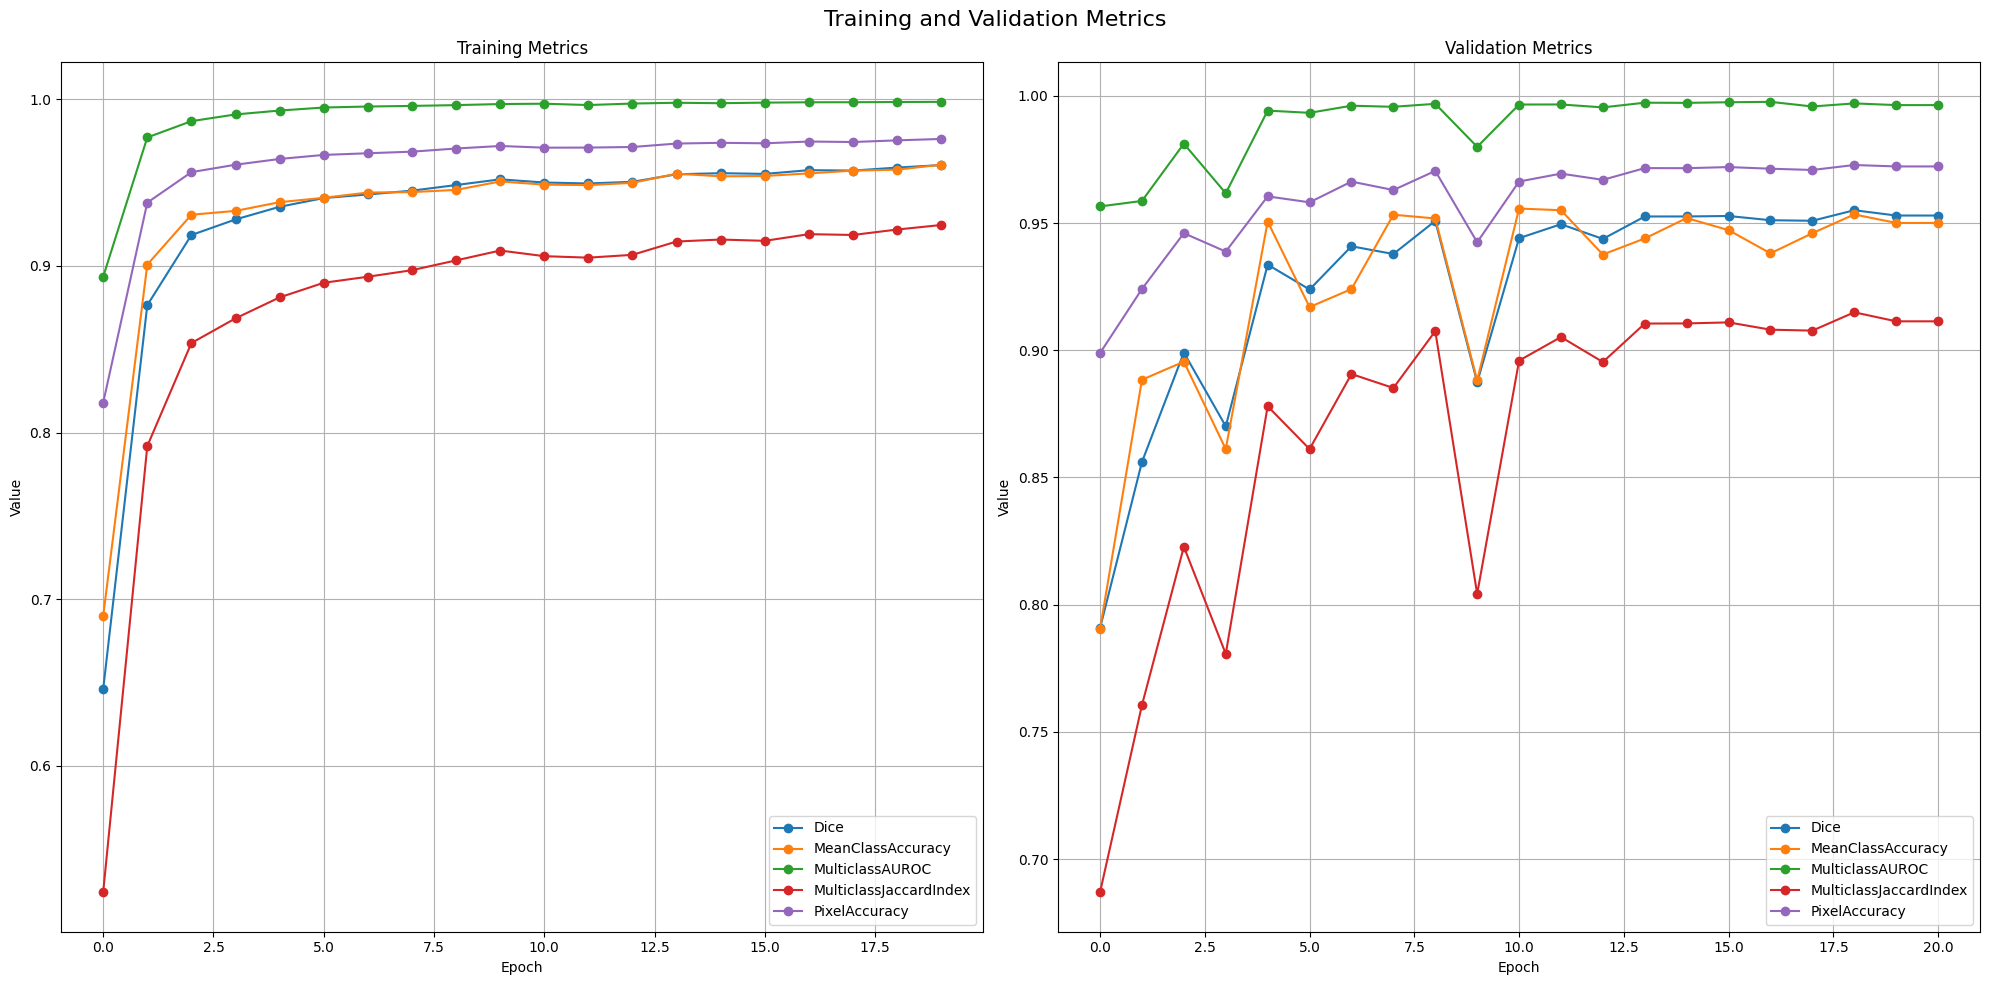

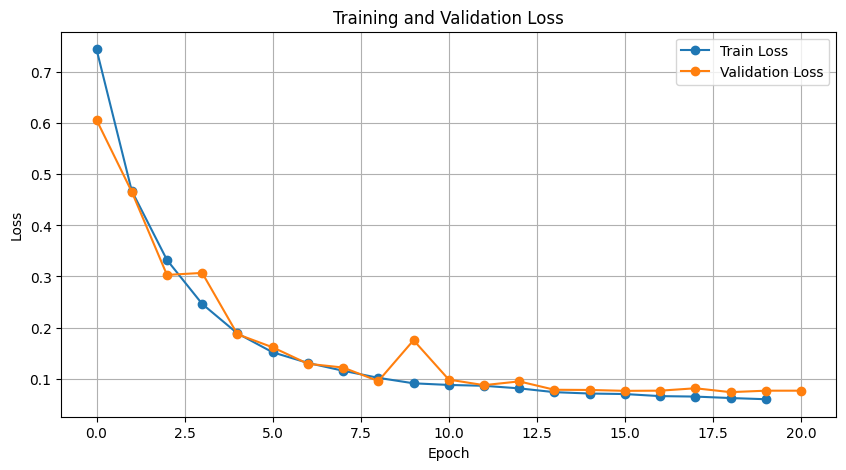

In [175]:
log_dir = "logs/lightning_logs/version_0"
metrics = pd.read_csv(f"{log_dir}/metrics.csv")

plt.figure(figsize=(20, 10))

train_metrics = [col for col in metrics.columns if col.startswith('train_') and col != 'train_loss']
val_metrics = [col for col in metrics.columns if col.startswith('val_') and col != 'val_loss']

plt.subplot(1, 2, 1)
for column in train_metrics:
    valid_data = metrics[['epoch', column]].dropna()
    plt.plot(valid_data['epoch'], valid_data[column], label=column.replace('train_', ''), marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for column in val_metrics:
    valid_data = metrics[['epoch', column]].dropna()
    plt.plot(valid_data['epoch'], valid_data[column], label=column.replace('val_', ''), marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)

plt.suptitle('Training and Validation Metrics', fontsize=16)

plt.tight_layout()

plt.savefig('metrics_plot_0.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
train_loss = metrics[['epoch', 'train_loss']].dropna()
val_loss = metrics[['epoch', 'val_loss']].dropna()

plt.plot(train_loss['epoch'], train_loss['train_loss'], label='Train Loss', marker='o')
plt.plot(val_loss['epoch'], val_loss['val_loss'], label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.savefig('loss_plot_0.png')
plt.show()
plt.close()

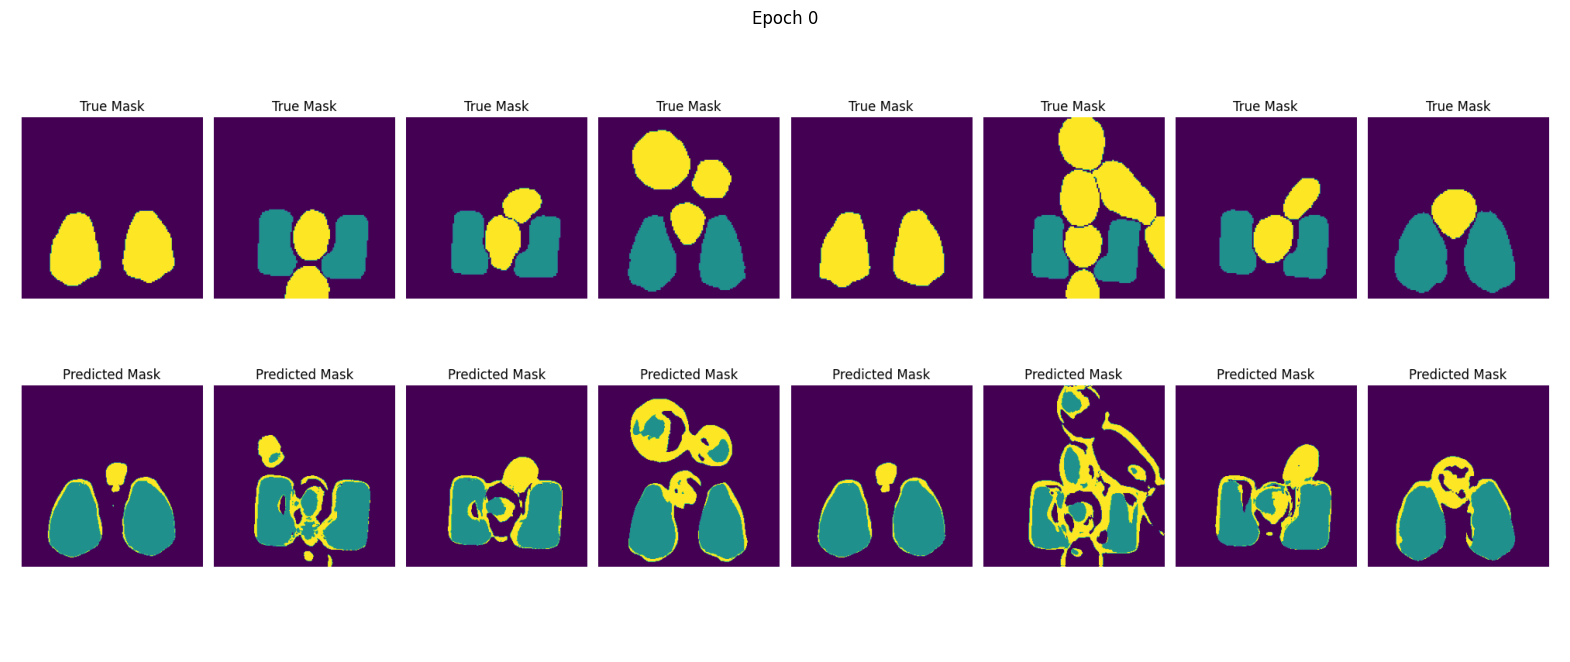

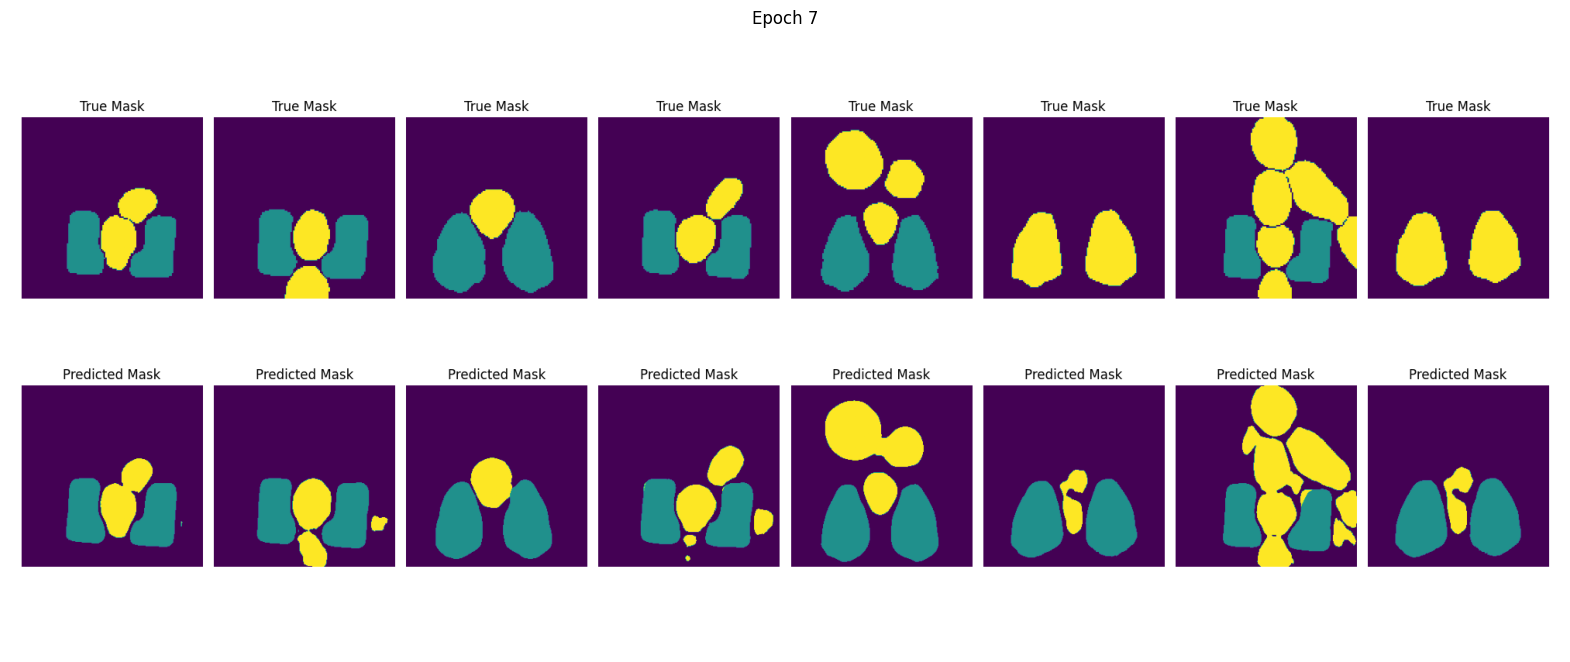

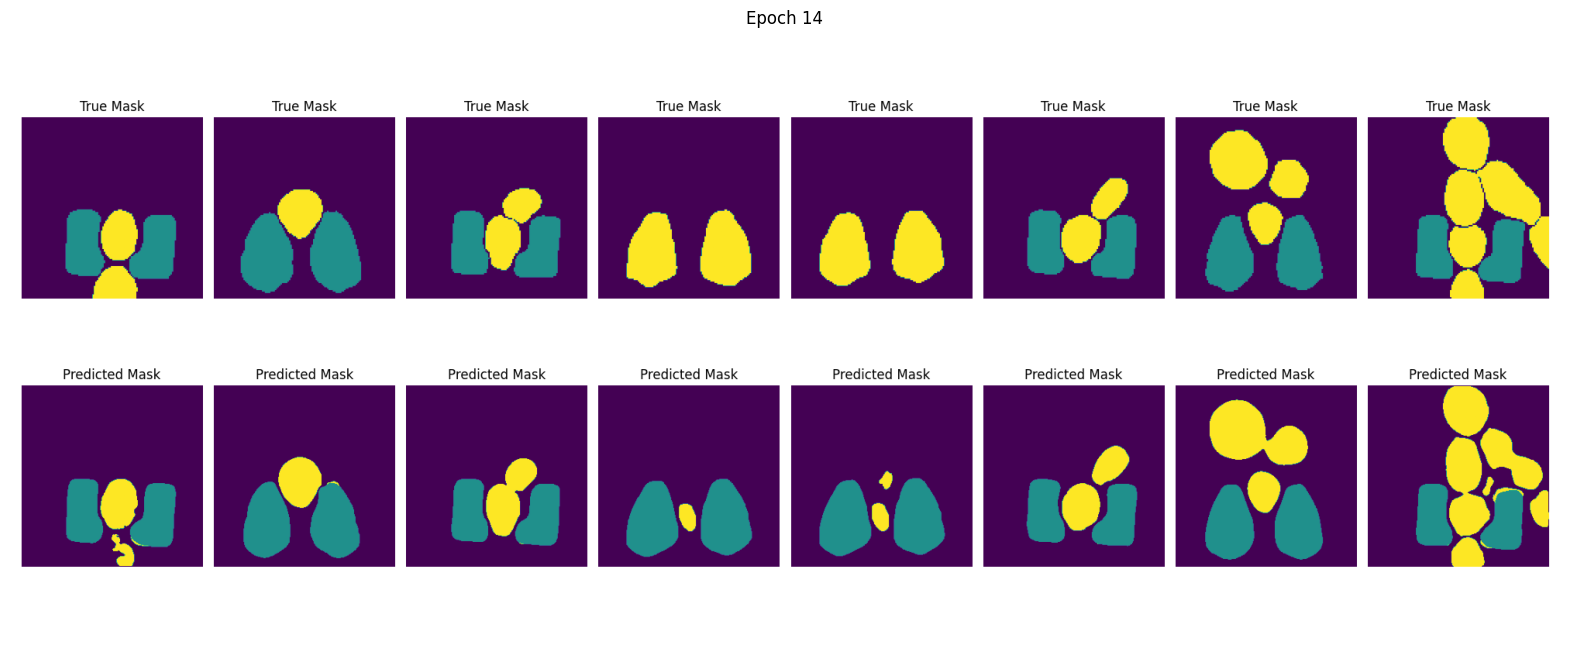

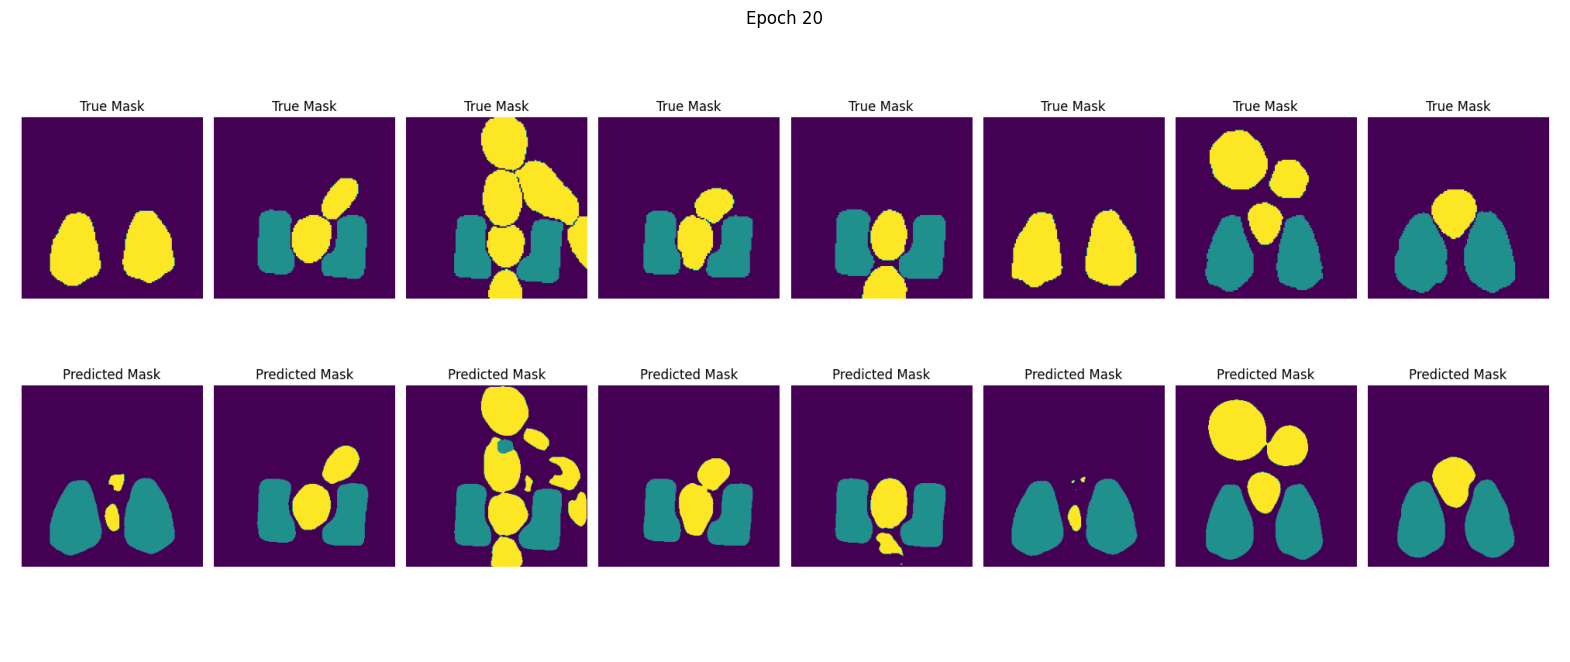

In [176]:
def show_saved_visualizations(saved_images, num_to_show=4):
    epochs = sorted(saved_images.keys())
    num_epochs = len(epochs)

    epochs_to_show = [epochs[0]]
    if num_epochs > 3:
        epochs_to_show.extend([epochs[num_epochs // 3], epochs[2 * num_epochs // 3]])
    epochs_to_show.append(epochs[-1])

    epochs_to_show = epochs_to_show[:num_to_show]

    for epoch in epochs_to_show:
        img = plt.imread(saved_images[epoch])
        plt.figure(figsize=(20, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {epoch}')
        plt.show()

show_saved_visualizations(visualization_callback.saved_images, num_to_show=4)

### Задание 3 (3 балла). Выбор другой функции ошибки

Полезная ссылка:
https://www.jeremyjordan.me/semantic-segmentation/#loss

Повторите эксперимент из задания 2, но попробуйте модифицировать функцию ошибки:
- (2 балла) учитывайте пиксели на границе объектов с большим весом, как предлагается в статье [U-Net](https://arxiv.org/abs/1505.04597)
- (1 балл) используйте soft Dice loss

Опишите свои наблюдения, что изменилось? Обратите внимание на скорость обучения, визуальные артефакты предсказаний, динамику метрик.


In [177]:
def boundary_aware_cross_entropy(pred, target, boundary_weight=1.5):
    ce_loss = F.cross_entropy(pred, target, reduction='none')

    boundary_kernel = torch.tensor([[-1, -1, -1],
                                    [-1,  8, -1],
                                    [-1, -1, -1]], dtype=torch.float32, device=pred.device)
    boundary_kernel = boundary_kernel.view(1, 1, 3, 3)

    target_float = target.float().unsqueeze(1)
    boundary_map = F.conv2d(target_float, boundary_kernel, padding=1)
    boundary_map = torch.abs(boundary_map) > 0

    weighted_loss = torch.where(boundary_map.squeeze(1), ce_loss * boundary_weight, ce_loss)

    return weighted_loss.mean()

In [178]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
dm = Datamodule(dataset_dir, YeastSemanticSegmDataset, batch_size=8)

model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)

UNet_model = UNetModule_with_loss(model=model, optimizer=torch.optim.Adam, loss_function=boundary_aware_cross_entropy, learning_rate=0.001)

visualization_callback = VisualizationCallback(num_samples=8, num_exp=1)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=20,
    limit_train_batches=None,
    limit_val_batches=None,
    logger=L.pytorch.loggers.CSVLogger("logs"),
    callbacks=[visualization_callback]
)

trainer.fit(
    model=UNet_model,
    datamodule=dm,
)

trainer.validate(model=UNet_model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
87        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | P

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_Dice          │     0.9537396430969238     │
│   val_MeanClassAccuracy    │     0.9472999572753906     │
│    val_MulticlassAUROC     │     0.9974156618118286     │
│ val_MulticlassJaccardIndex │     0.9127470254898071     │
│     val_PixelAccuracy      │     0.9725774526596069     │
│          val_loss          │     0.0845288559794426     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.0845288559794426,
  'val_MulticlassJaccardIndex': 0.9127470254898071,
  'val_Dice': 0.9537396430969238,
  'val_MulticlassAUROC': 0.9974156618118286,
  'val_MeanClassAccuracy': 0.9472999572753906,
  'val_PixelAccuracy': 0.9725774526596069}]

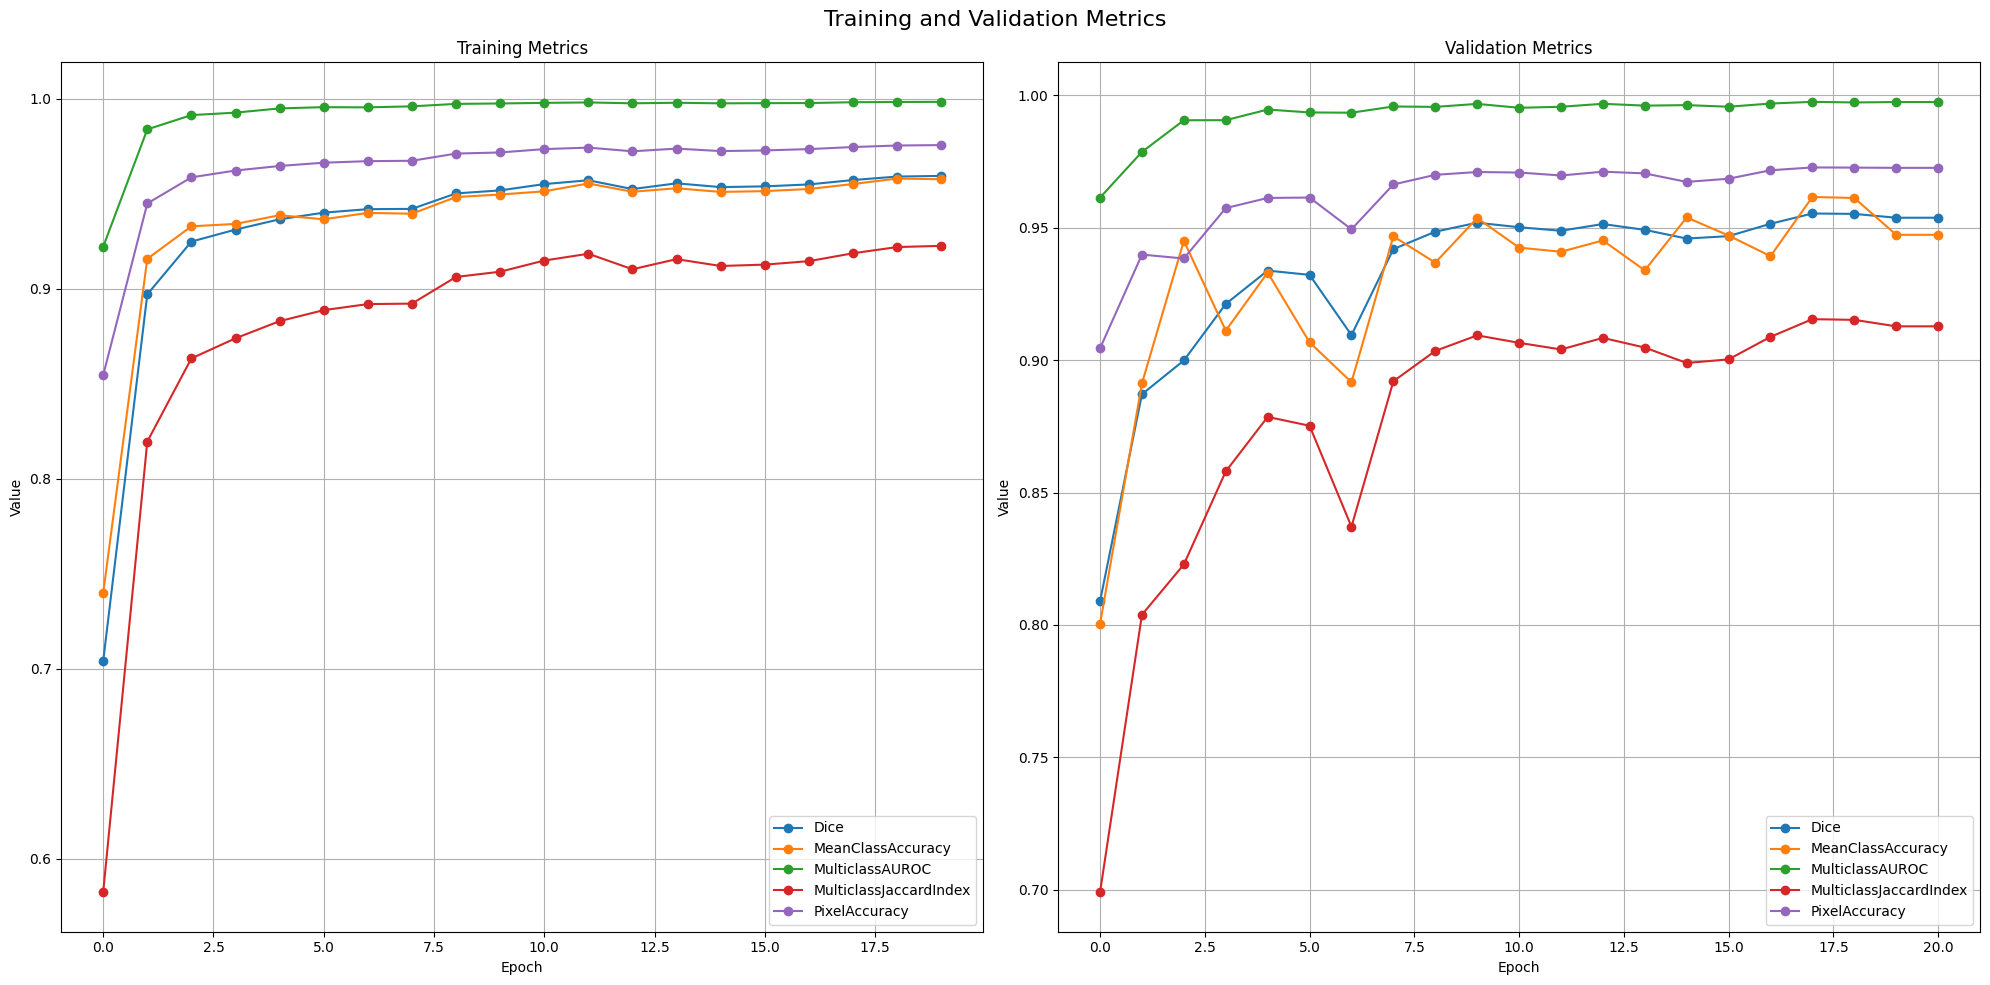

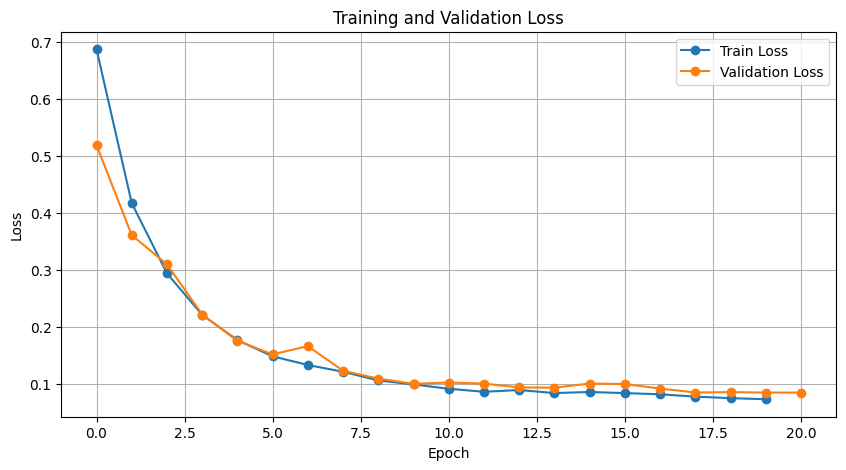

In [179]:
log_dir = "logs/lightning_logs/version_1"
metrics = pd.read_csv(f"{log_dir}/metrics.csv")

plt.figure(figsize=(20, 10))

train_metrics = [col for col in metrics.columns if col.startswith('train_') and col != 'train_loss']
val_metrics = [col for col in metrics.columns if col.startswith('val_') and col != 'val_loss']

plt.subplot(1, 2, 1)
for column in train_metrics:
    valid_data = metrics[['epoch', column]].dropna()
    plt.plot(valid_data['epoch'], valid_data[column], label=column.replace('train_', ''), marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for column in val_metrics:
    valid_data = metrics[['epoch', column]].dropna()
    plt.plot(valid_data['epoch'], valid_data[column], label=column.replace('val_', ''), marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)

plt.suptitle('Training and Validation Metrics', fontsize=16)

plt.tight_layout()

plt.savefig('metrics_plot_1.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
train_loss = metrics[['epoch', 'train_loss']].dropna()
val_loss = metrics[['epoch', 'val_loss']].dropna()

plt.plot(train_loss['epoch'], train_loss['train_loss'], label='Train Loss', marker='o')
plt.plot(val_loss['epoch'], val_loss['val_loss'], label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.savefig('loss_plot_1.png')
plt.show()
plt.close()

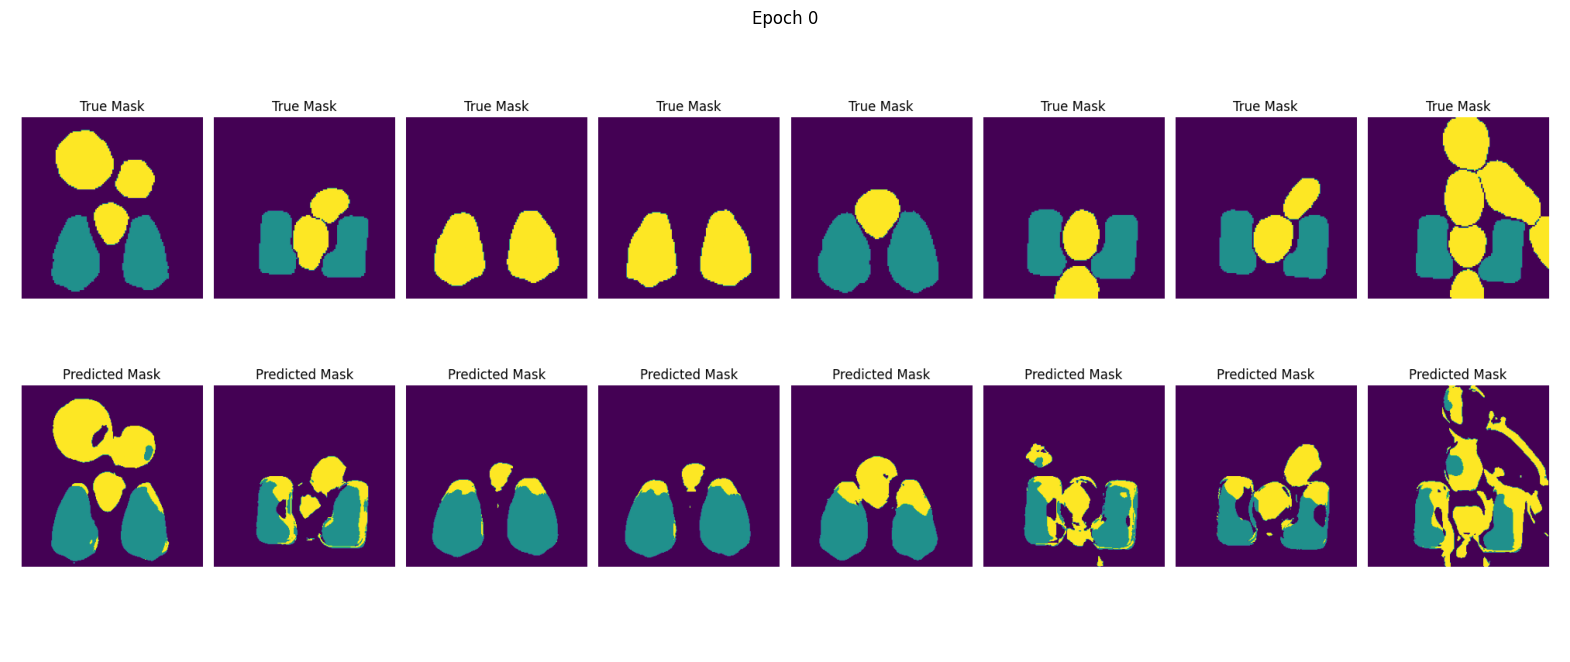

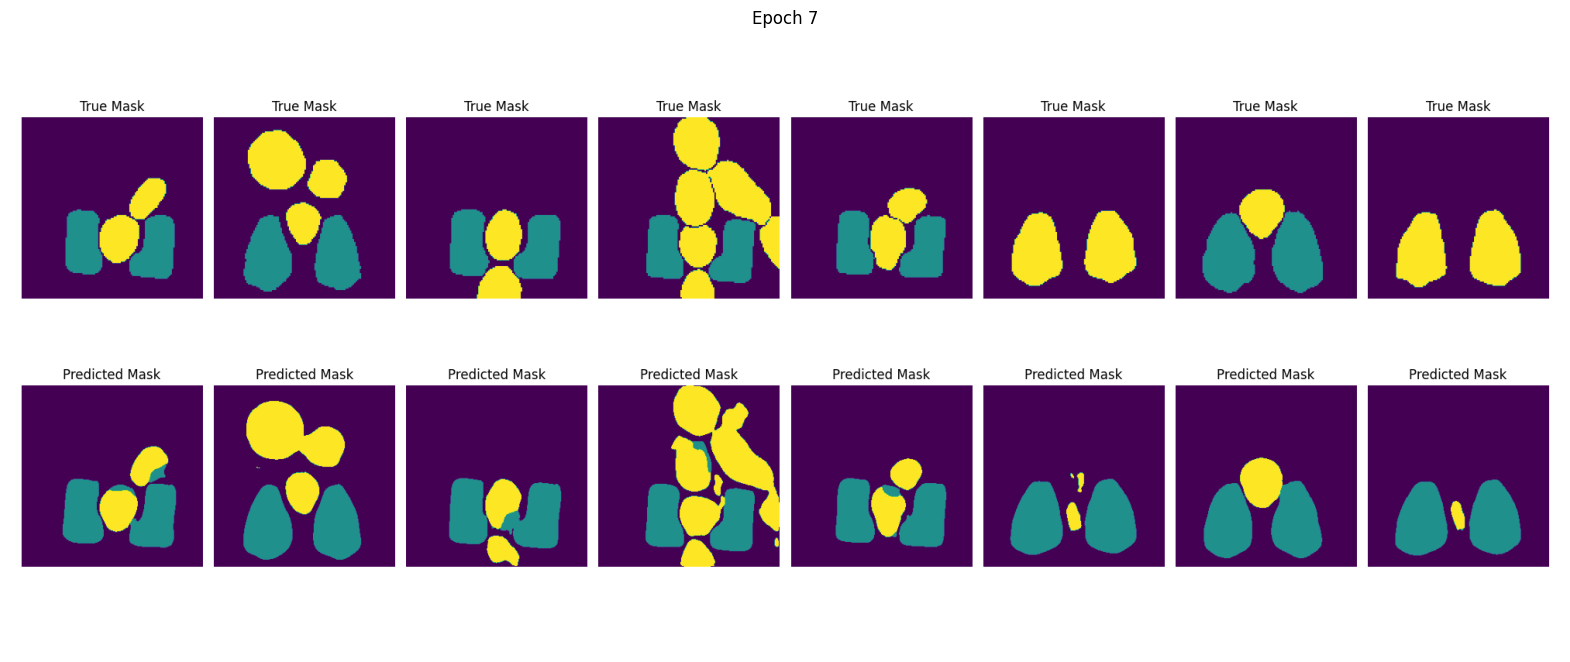

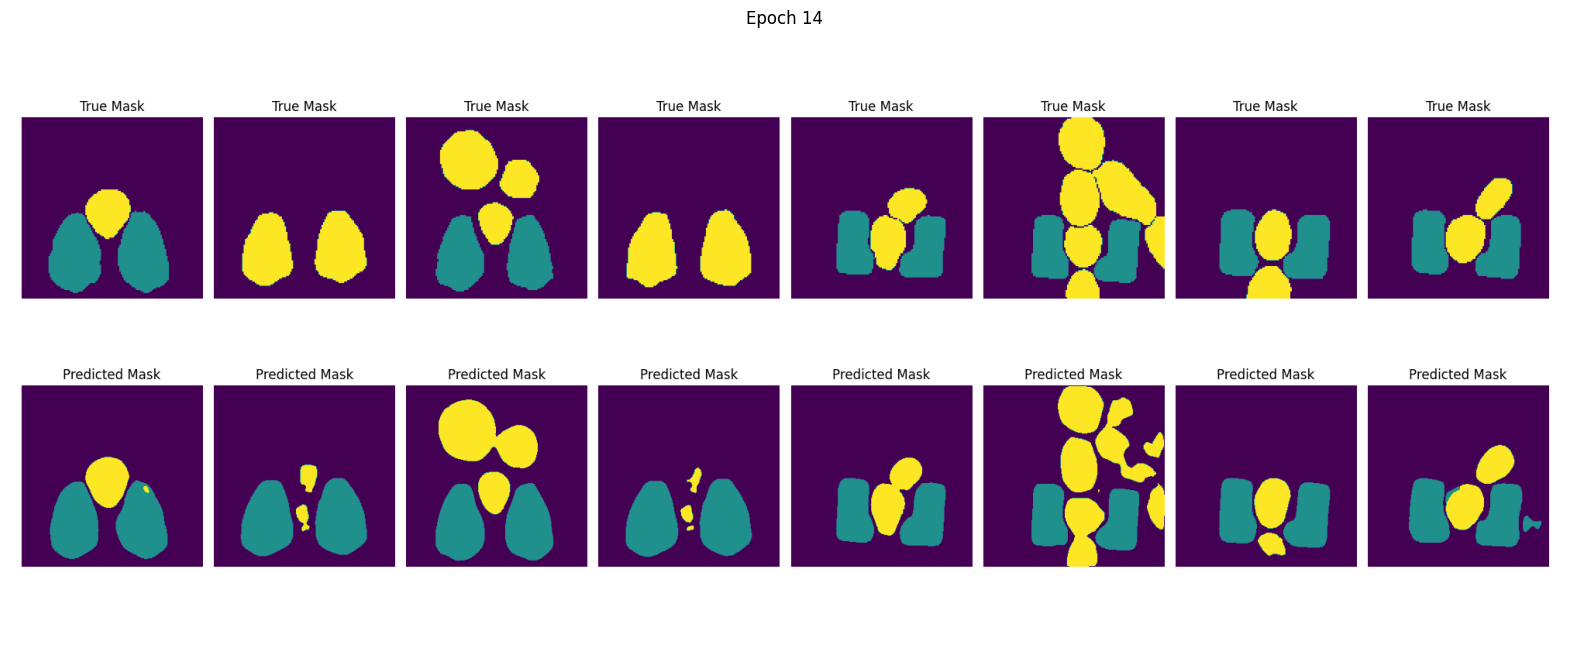

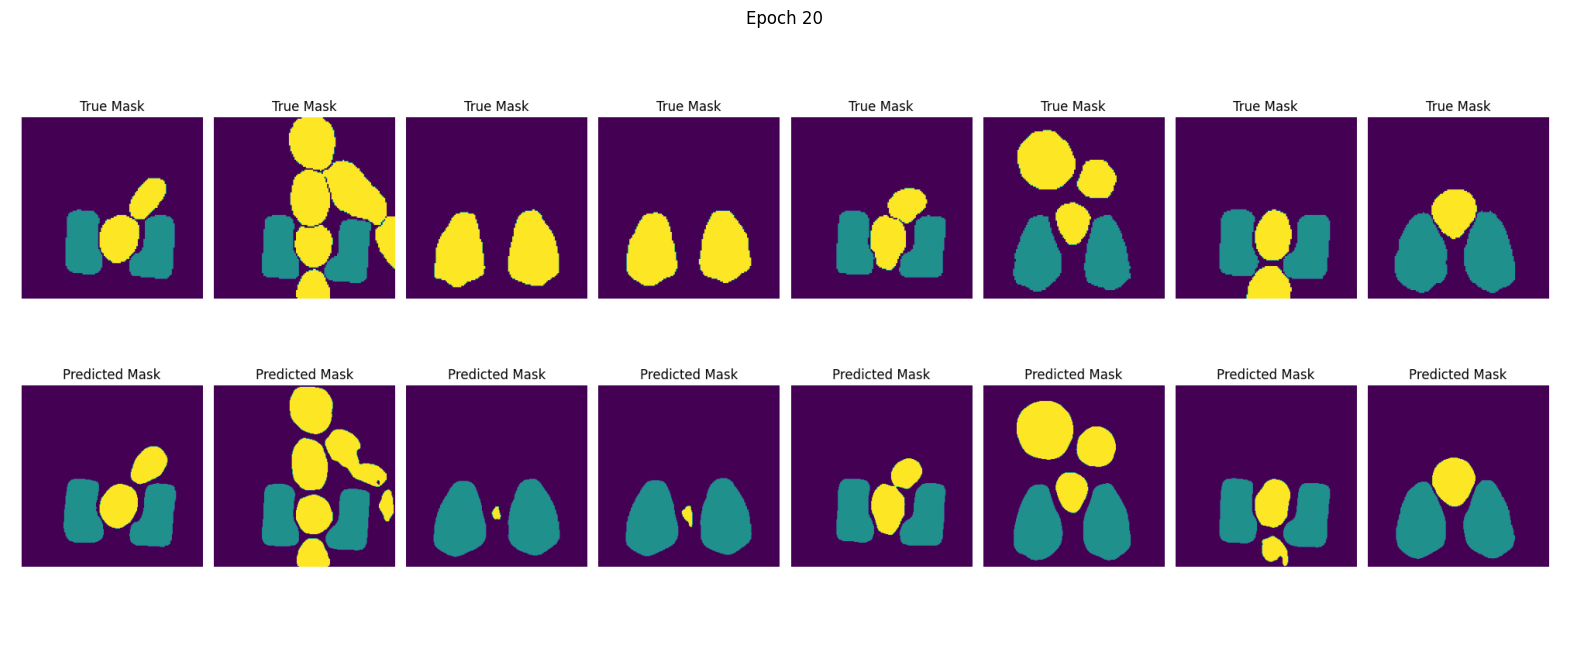

In [180]:
def show_saved_visualizations(saved_images, num_to_show=4):
    epochs = sorted(saved_images.keys())
    num_epochs = len(epochs)

    epochs_to_show = [epochs[0]]
    if num_epochs > 3:
        epochs_to_show.extend([epochs[num_epochs // 3], epochs[2 * num_epochs // 3]])
    epochs_to_show.append(epochs[-1])

    epochs_to_show = epochs_to_show[:num_to_show]

    for epoch in epochs_to_show:
        img = plt.imread(saved_images[epoch])
        plt.figure(figsize=(20, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {epoch}')
        plt.show()

show_saved_visualizations(visualization_callback.saved_images, num_to_show=4)

In [181]:
def soft_dice_loss(predicted, target, smooth=1e-6):
    num_classes = predicted.size(1)

    predicted = F.softmax(predicted, dim=1)

    target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()

    dice_loss = 0
    for class_index in range(num_classes):
        pred_class = predicted[:, class_index, :, :]
        target_class = target_one_hot[:, class_index, :, :]

        numerator = (pred_class * target_class).sum()
        denominator = pred_class.sum() + target_class.sum()

        dice_score = (2.0 * numerator + smooth) / (denominator + smooth)
        dice_loss += 1 - dice_score

    return dice_loss / num_classes

In [182]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
dm = Datamodule(dataset_dir, YeastSemanticSegmDataset, batch_size=8)

model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)

UNet_model = UNetModule_with_loss(model=model, optimizer=torch.optim.Adam, loss_function=soft_dice_loss, learning_rate=0.001)

visualization_callback = VisualizationCallback(num_samples=8, num_exp=2)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=20,
    limit_train_batches=None,
    limit_val_batches=None,
    logger=L.pytorch.loggers.CSVLogger("logs"),
    callbacks=[visualization_callback]
)

trainer.fit(
    model=UNet_model,
    datamodule=dm,
)

trainer.validate(model=UNet_model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
87        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | P

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_Dice          │     0.9540138244628906     │
│   val_MeanClassAccuracy    │     0.9574512243270874     │
│    val_MulticlassAUROC     │     0.9797004461288452     │
│ val_MulticlassJaccardIndex │     0.9131758213043213     │
│     val_PixelAccuracy      │     0.9721651673316956     │
│          val_loss          │    0.049285925924777985    │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.049285925924777985,
  'val_MulticlassJaccardIndex': 0.9131758213043213,
  'val_Dice': 0.9540138244628906,
  'val_MulticlassAUROC': 0.9797004461288452,
  'val_MeanClassAccuracy': 0.9574512243270874,
  'val_PixelAccuracy': 0.9721651673316956}]

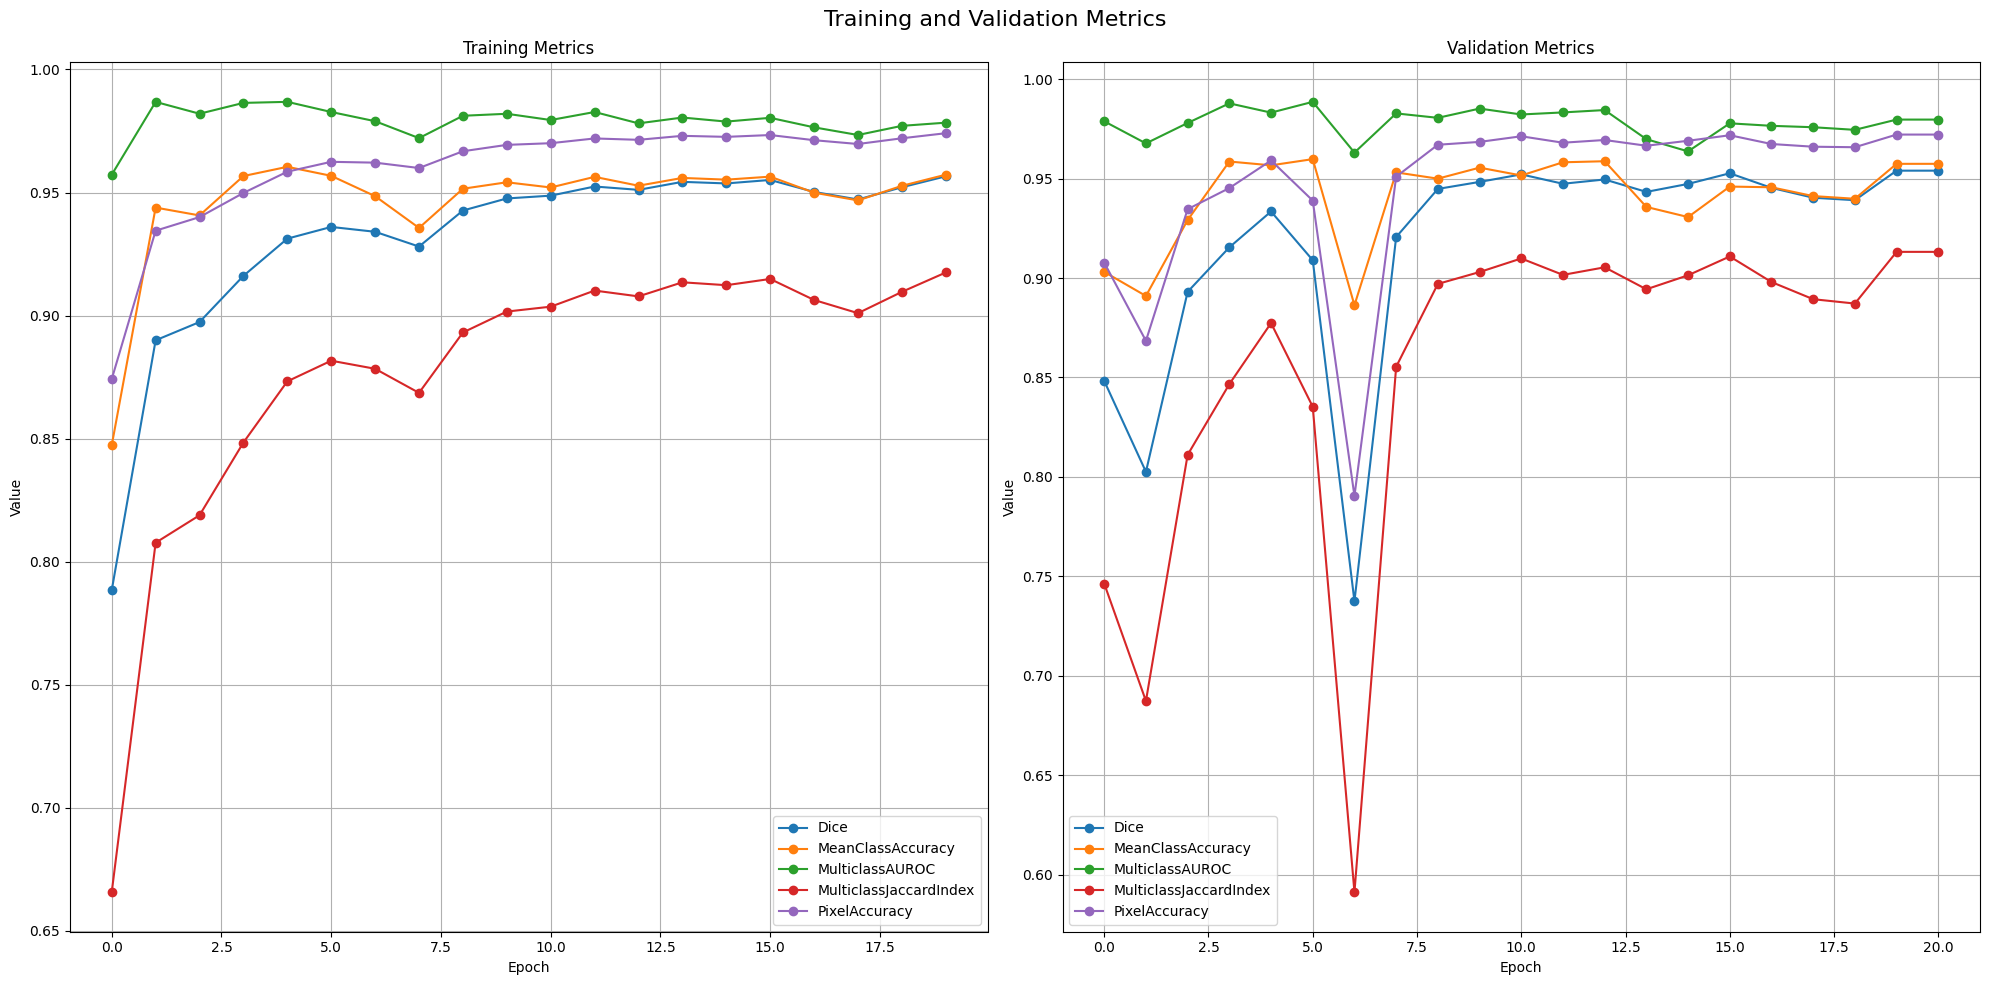

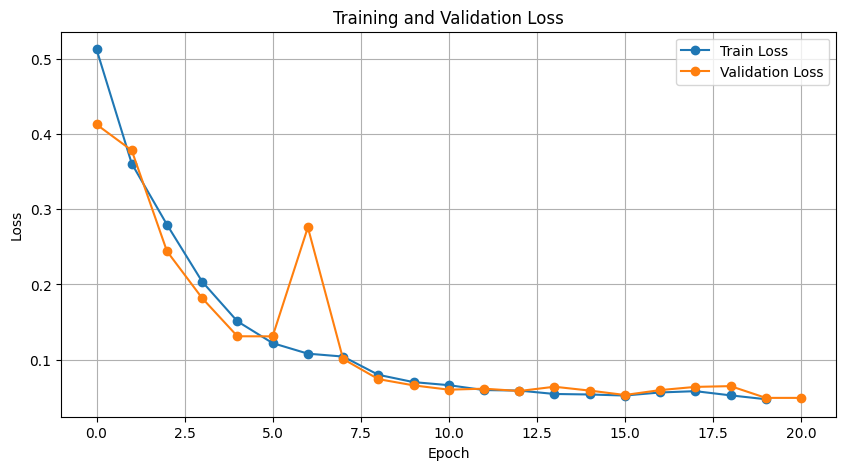

In [183]:
log_dir = "logs/lightning_logs/version_2"
metrics = pd.read_csv(f"{log_dir}/metrics.csv")

plt.figure(figsize=(20, 10))

train_metrics = [col for col in metrics.columns if col.startswith('train_') and col != 'train_loss']
val_metrics = [col for col in metrics.columns if col.startswith('val_') and col != 'val_loss']

plt.subplot(1, 2, 1)
for column in train_metrics:
    valid_data = metrics[['epoch', column]].dropna()
    plt.plot(valid_data['epoch'], valid_data[column], label=column.replace('train_', ''), marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for column in val_metrics:
    valid_data = metrics[['epoch', column]].dropna()
    plt.plot(valid_data['epoch'], valid_data[column], label=column.replace('val_', ''), marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)

plt.suptitle('Training and Validation Metrics', fontsize=16)

plt.tight_layout()

plt.savefig('metrics_plot_2.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
train_loss = metrics[['epoch', 'train_loss']].dropna()
val_loss = metrics[['epoch', 'val_loss']].dropna()

plt.plot(train_loss['epoch'], train_loss['train_loss'], label='Train Loss', marker='o')
plt.plot(val_loss['epoch'], val_loss['val_loss'], label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.savefig('loss_plot_2.png')
plt.show()
plt.close()

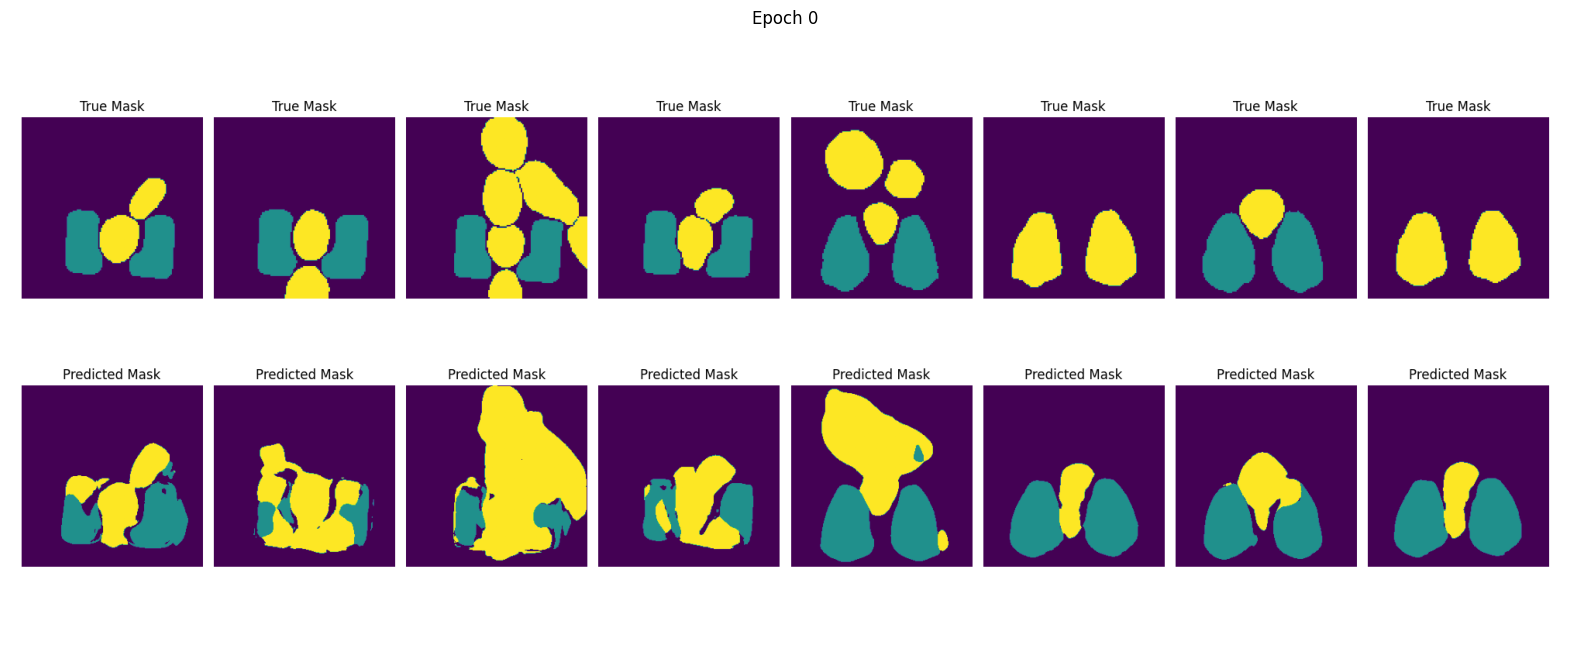

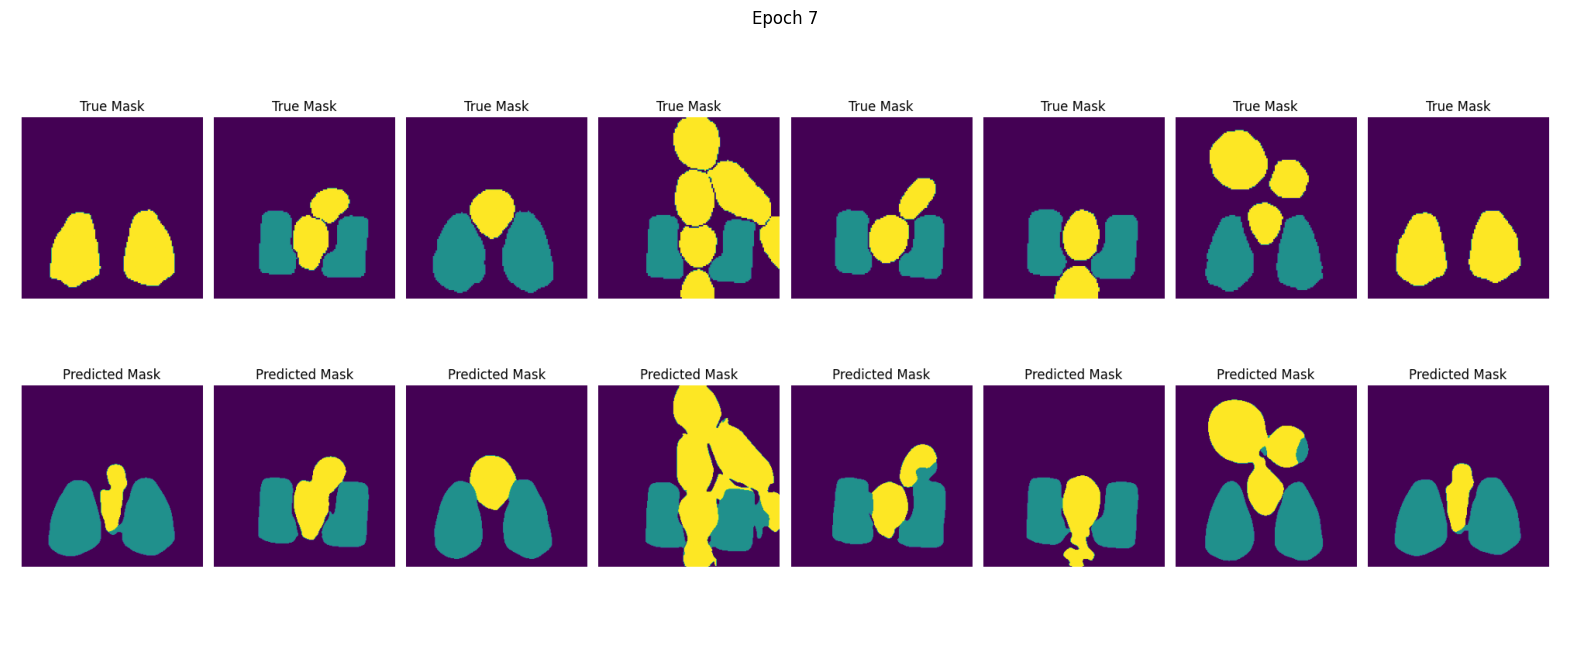

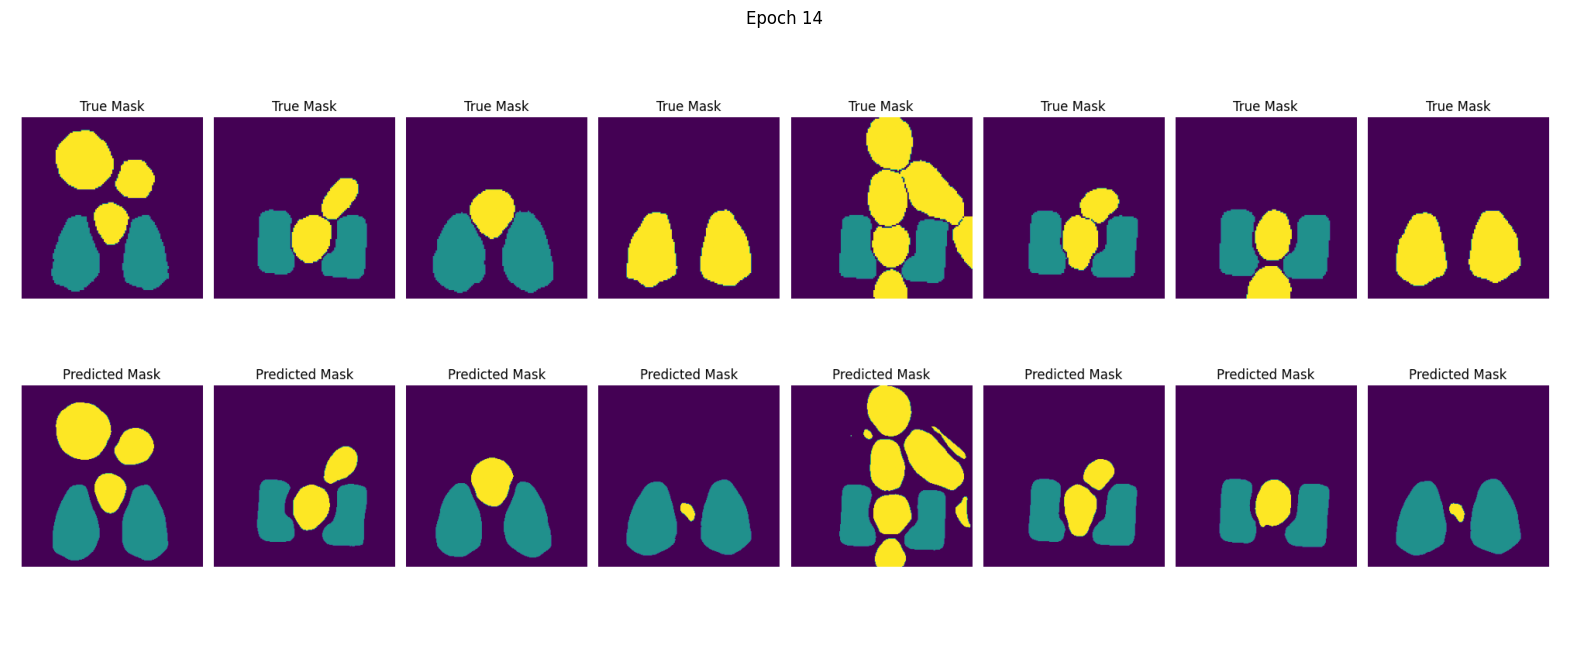

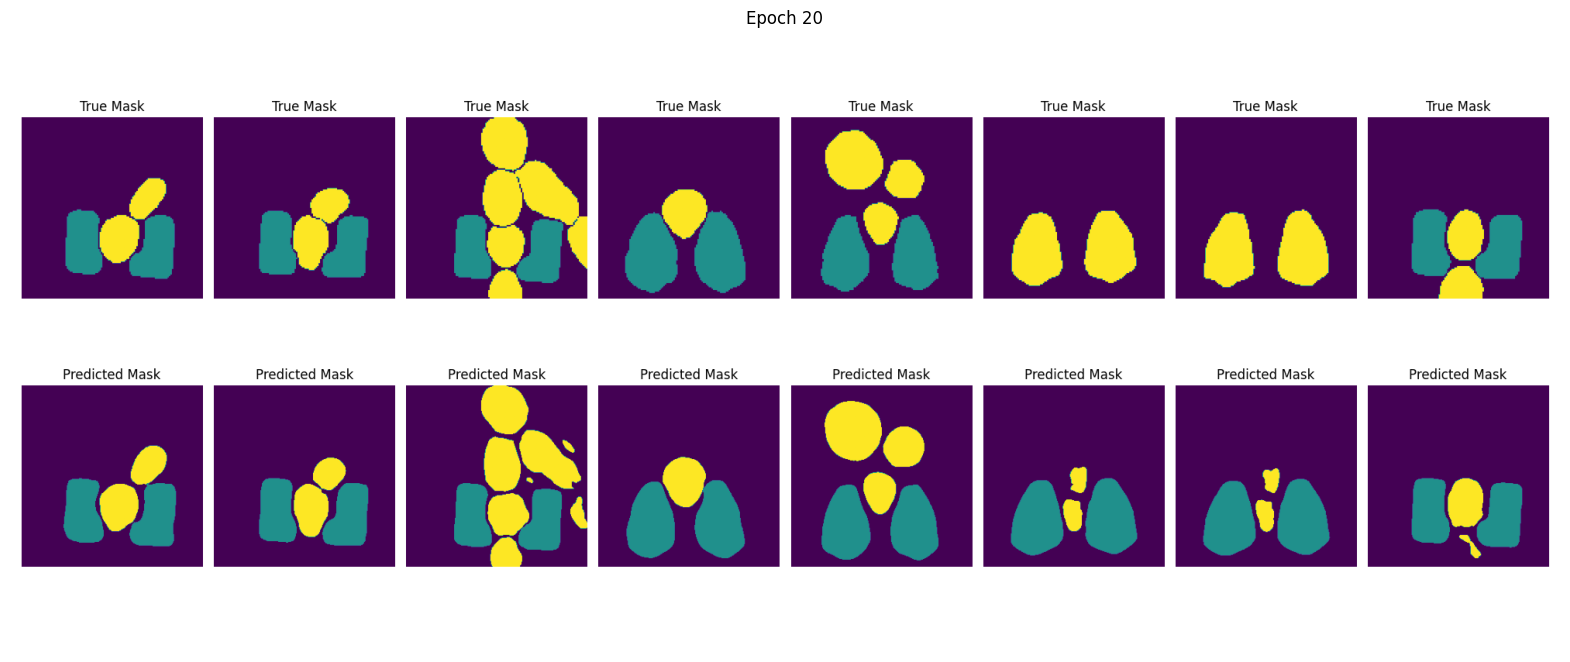

In [184]:
def show_saved_visualizations(saved_images, num_to_show=4):
    epochs = sorted(saved_images.keys())
    num_epochs = len(epochs)

    epochs_to_show = [epochs[0]]
    if num_epochs > 3:
        epochs_to_show.extend([epochs[num_epochs // 3], epochs[2 * num_epochs // 3]])
    epochs_to_show.append(epochs[-1])

    epochs_to_show = epochs_to_show[:num_to_show]

    for epoch in epochs_to_show:
        img = plt.imread(saved_images[epoch])
        plt.figure(figsize=(20, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {epoch}')
        plt.show()

show_saved_visualizations(visualization_callback.saved_images, num_to_show=4)

### Вывод

1. Из полученных значений метрик можно сделать вывод, что при использовании метрики, учитывающей пиксели на границе объектов, точность определения границ несколько возрасла. При использовании же soft Dice точность границ напротив заметно понизилась. При этом обе новые метрики, возможно, немного повысили общую точность предсказаний.

2. В обоих случаях из графиков можно заметить, что скорость обучения немного уменьшилась по сравнению с использованием Кросс Энтропии.

3. Учитвая визуальные артефакты, можно заметить, как метрика, учитывающая пиксели на границе объектов, влияет на процесс обучения: в первую очередь начинают выделяться именно границы. Результаты использования soft Dice после 15 эпох также выглядят удовлетворительно.

По совокупности факторов наиболее удачной метрикой потерь кажется метрика, учитывающая пиксели на границе объектов с большим весом. Хотя по параметрам на выходе разница с обычной Кросс Энтропией не сильно заметна.

### Задание 4 (3 балла). Модификация архитектуры

Ваша задача - извлечь максимальную точность из модели, в которой будет не более 50k параметров. Для этого внесите правки в архитектуру модели.

В частности, попробуйте заменить в блоке `Down` комбинацию conv+maxpool на dilated conv (`nn.Conv2d(..., dilation=2)`). В остальном - полная свобода творчества, можете перерабатывать архитектуру как угодно.

Как обычно, запустите эксперимент (или несколько) с выводом всех графиков и картинок.

Блок Down изменен так, как предлагается. Уменьшено число каналов в Unet.

In [185]:
class Down_2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, dilation=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [186]:
class UNet_2(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down_2(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        xs = []
        x = self.in_conv(x)

        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        logits = self.head(x)
        return logits

In [187]:
model = UNet_2(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64], bilinear=True)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 46627


In [188]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
dm = Datamodule(dataset_dir, YeastSemanticSegmDataset, batch_size=8)

model = UNet_2(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64], bilinear=True)

UNet_model = UNetModule_with_loss(model=model, optimizer=torch.optim.Adam, loss_function=boundary_aware_cross_entropy, learning_rate=0.001)

visualization_callback = VisualizationCallback(num_samples=8, num_exp=3)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=25,
    limit_train_batches=None,
    limit_val_batches=None,
    logger=L.pytorch.loggers.CSVLogger("logs"),
    callbacks=[visualization_callback]
)

trainer.fit(
    model=UNet_model,
    datamodule=dm,
)

trainer.validate(model=UNet_model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet_2           | 46.6 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
46.6 K    Trainable params
0         Non-trainable params
46.6 K    Total params
0.187     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | P

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_Dice          │     0.9189505577087402     │
│   val_MeanClassAccuracy    │     0.9089843034744263     │
│    val_MulticlassAUROC     │     0.9924925565719604     │
│ val_MulticlassJaccardIndex │     0.854955792427063      │
│     val_PixelAccuracy      │     0.9554682970046997     │
│          val_loss          │     0.1317892223596573     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.1317892223596573,
  'val_MulticlassJaccardIndex': 0.854955792427063,
  'val_Dice': 0.9189505577087402,
  'val_MulticlassAUROC': 0.9924925565719604,
  'val_MeanClassAccuracy': 0.9089843034744263,
  'val_PixelAccuracy': 0.9554682970046997}]

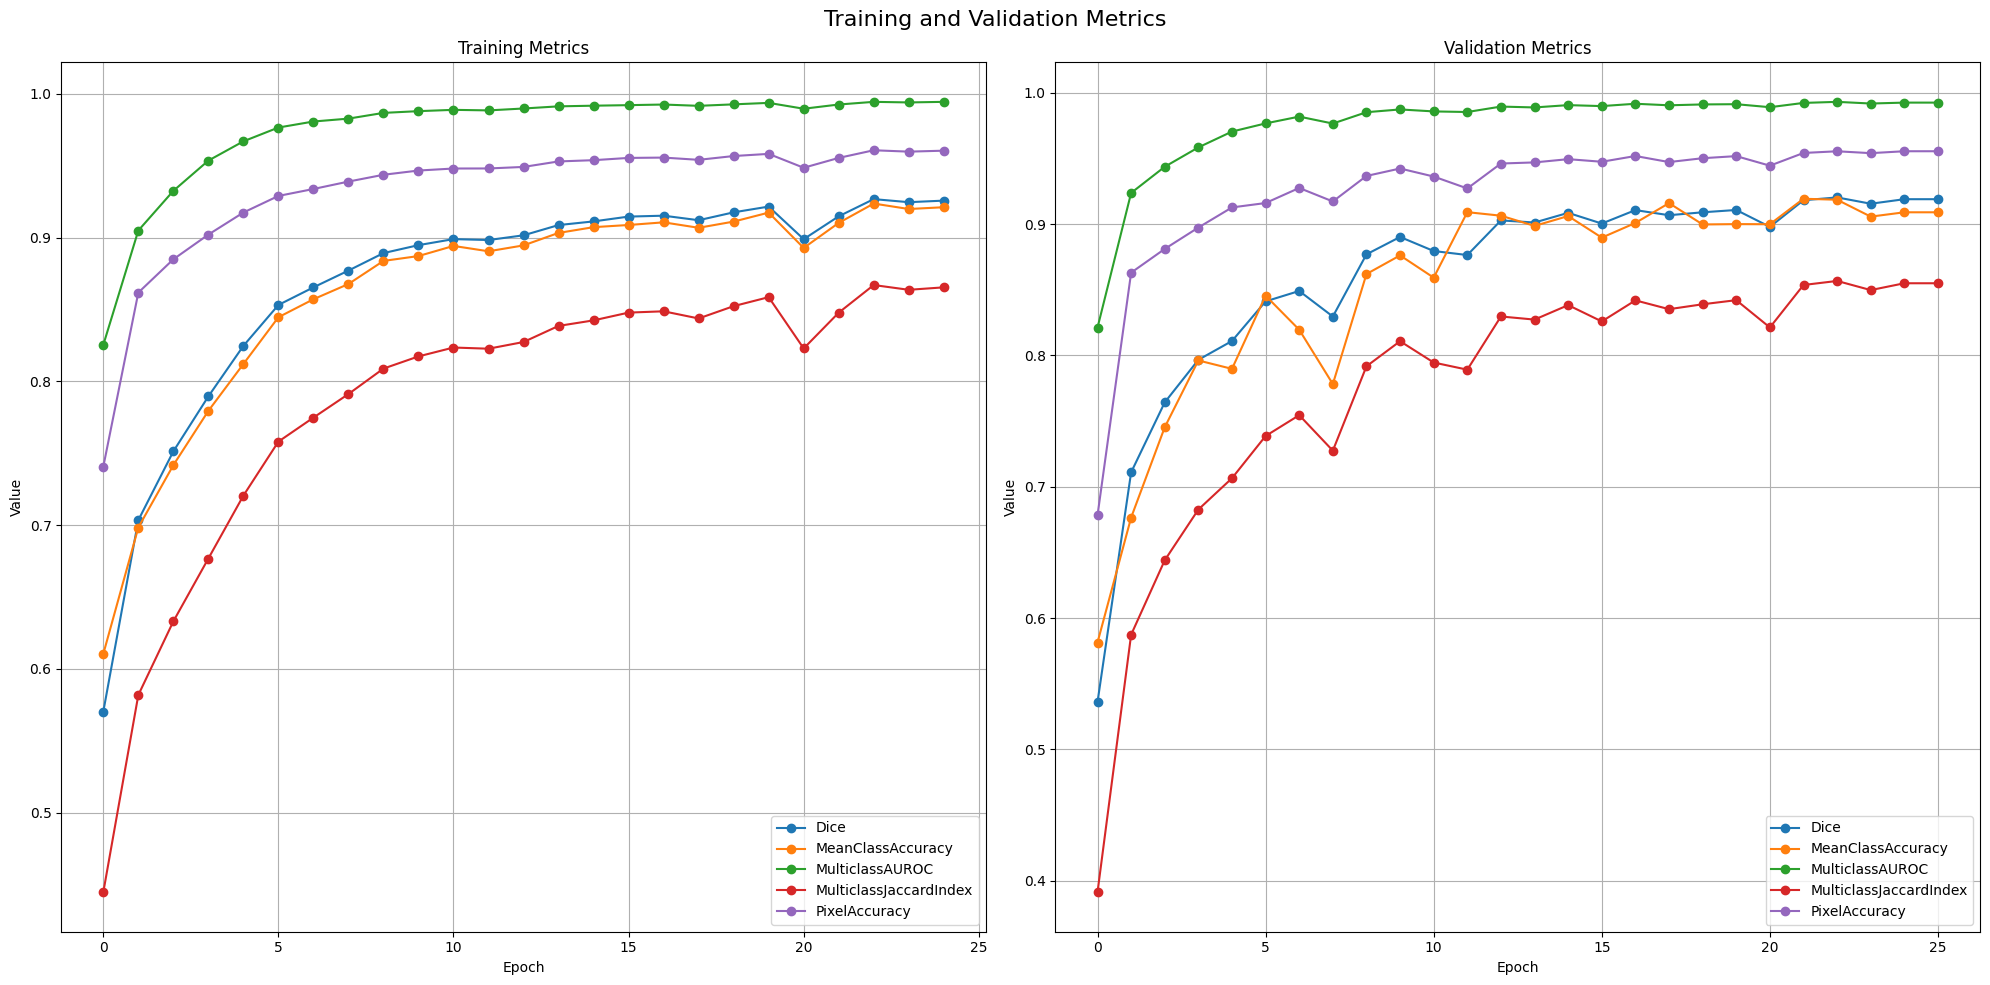

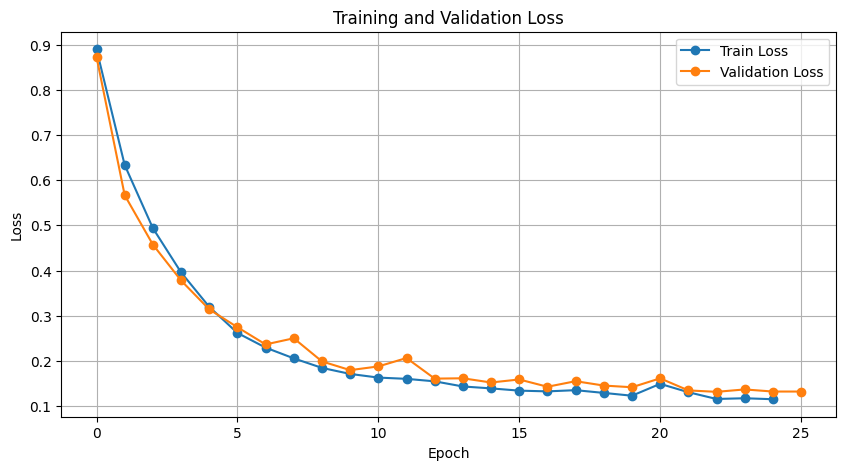

In [189]:
log_dir = "logs/lightning_logs/version_3"
metrics = pd.read_csv(f"{log_dir}/metrics.csv")

plt.figure(figsize=(20, 10))

train_metrics = [col for col in metrics.columns if col.startswith('train_') and col != 'train_loss']
val_metrics = [col for col in metrics.columns if col.startswith('val_') and col != 'val_loss']

plt.subplot(1, 2, 1)
for column in train_metrics:
    valid_data = metrics[['epoch', column]].dropna()
    plt.plot(valid_data['epoch'], valid_data[column], label=column.replace('train_', ''), marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for column in val_metrics:
    valid_data = metrics[['epoch', column]].dropna()
    plt.plot(valid_data['epoch'], valid_data[column], label=column.replace('val_', ''), marker='o')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)

plt.suptitle('Training and Validation Metrics', fontsize=16)

plt.tight_layout()

plt.savefig('metrics_plot_3.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
train_loss = metrics[['epoch', 'train_loss']].dropna()
val_loss = metrics[['epoch', 'val_loss']].dropna()

plt.plot(train_loss['epoch'], train_loss['train_loss'], label='Train Loss', marker='o')
plt.plot(val_loss['epoch'], val_loss['val_loss'], label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.savefig('loss_plot_3.png')
plt.show()
plt.close()

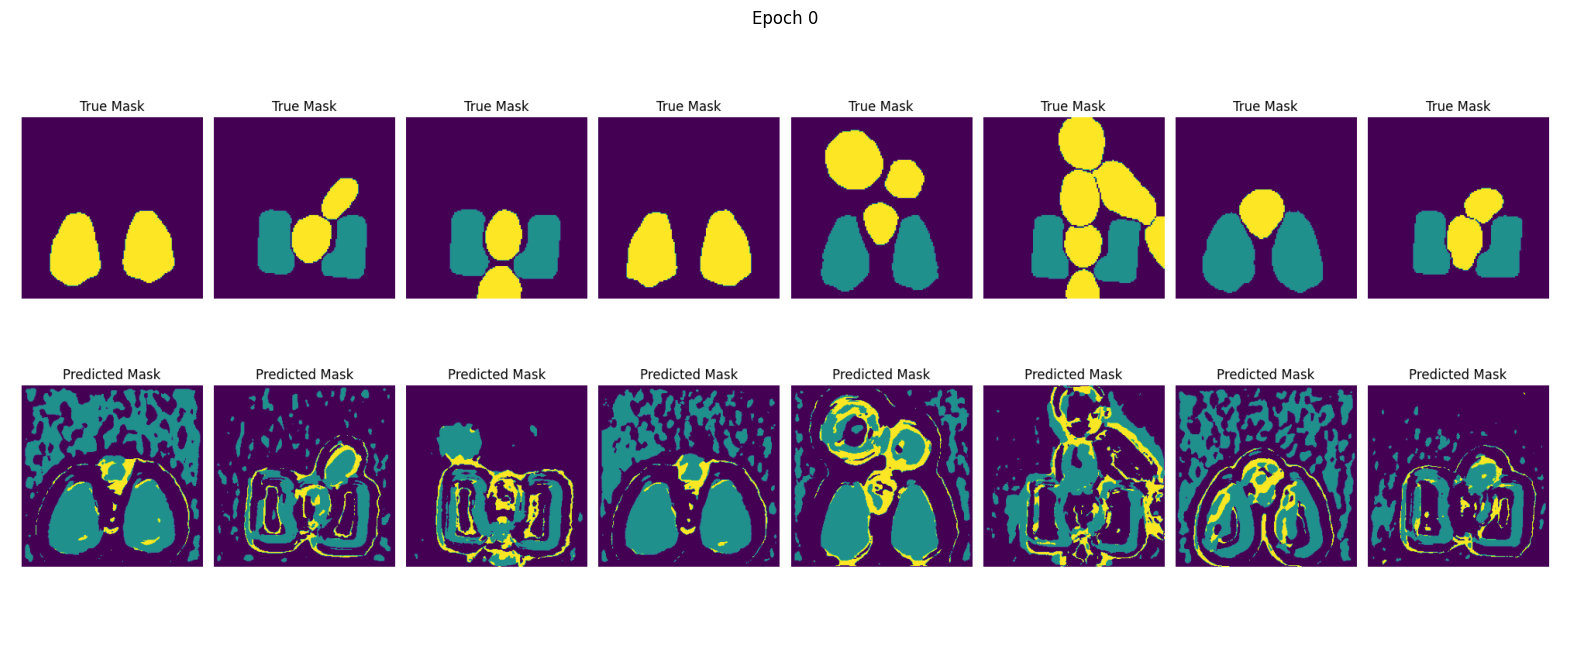

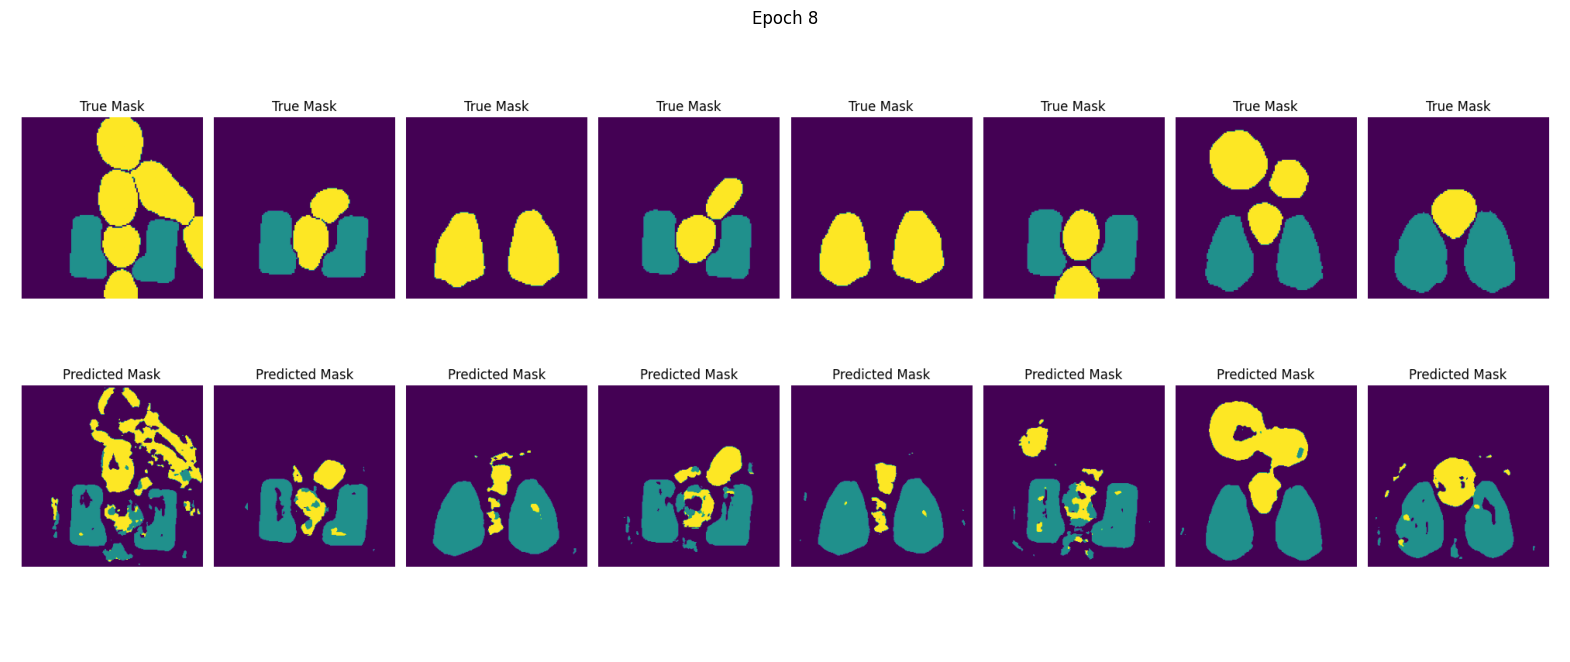

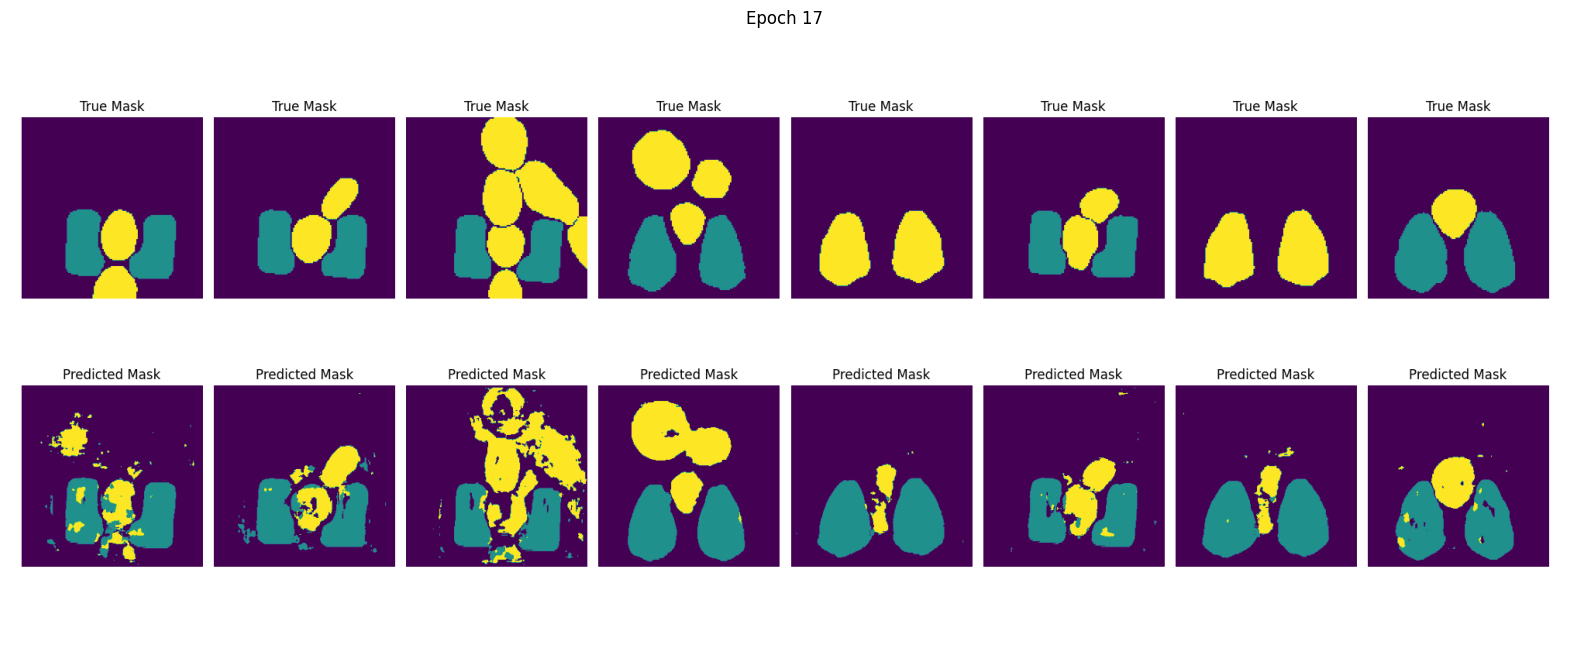

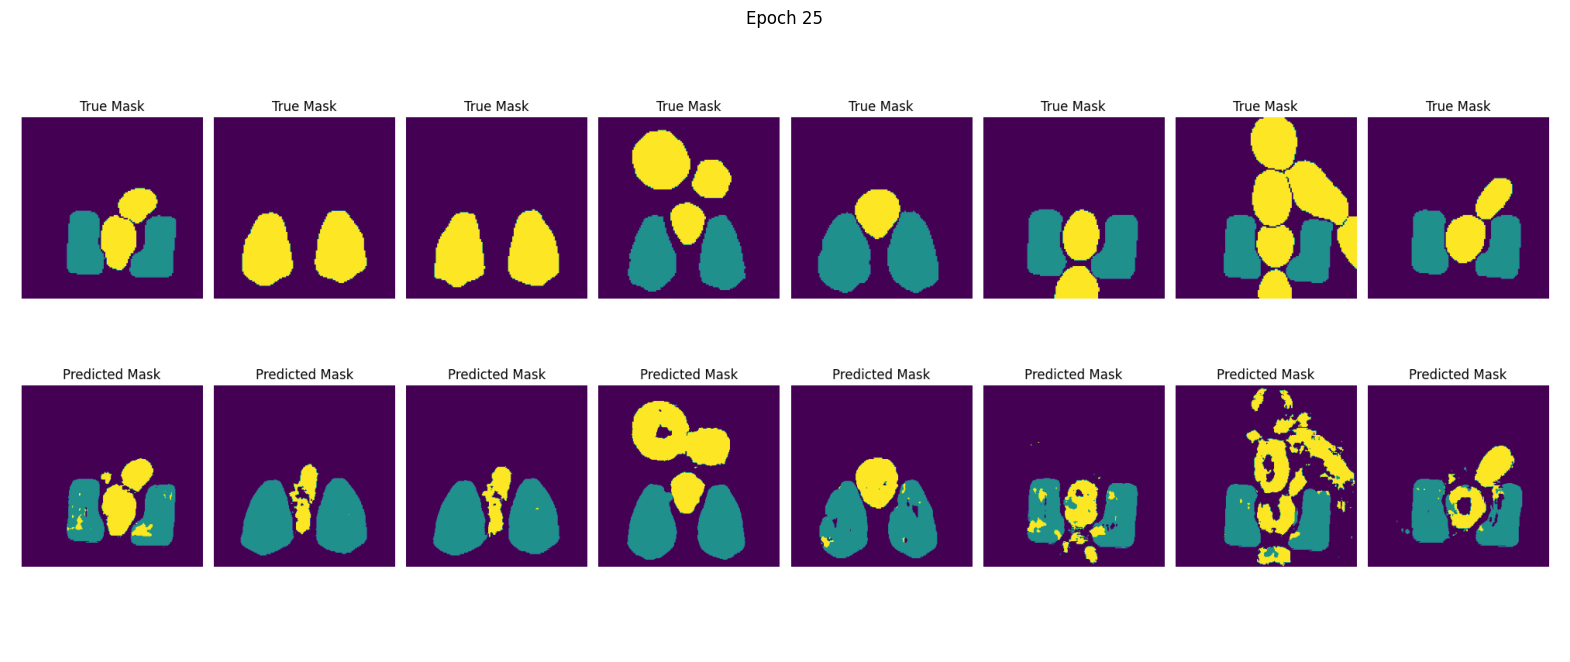

In [190]:
def show_saved_visualizations(saved_images, num_to_show=4):
    epochs = sorted(saved_images.keys())
    num_epochs = len(epochs)

    epochs_to_show = [epochs[0]]
    if num_epochs > 3:
        epochs_to_show.extend([epochs[num_epochs // 3], epochs[2 * num_epochs // 3]])
    epochs_to_show.append(epochs[-1])

    epochs_to_show = epochs_to_show[:num_to_show]

    for epoch in epochs_to_show:
        img = plt.imread(saved_images[epoch])
        plt.figure(figsize=(20, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {epoch}')
        plt.show()

show_saved_visualizations(visualization_callback.saved_images, num_to_show=4)